In [1]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cf
import geopandas
import yaml
import numpy as np
import pandas as pd
import shap
import pickle
import datetime
import os
import shapely
from matplotlib.collections import PatchCollection
from matplotlib.collections import PolyCollection
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from netCDF4 import Dataset
import sys

sys.path.insert(1,"../tools/")
from tol_colors import tol_cmap,tol_cset

def rmse(ytrue,ypred):
    n = len(ytrue)
    return ((1/n)*np.sum((ytrue-ypred)**2))**0.5

def r(ytrue,ypred):
    n = len(ytrue)
    return (n*np.sum(ytrue*ypred) - np.sum(ytrue)*np.sum(ypred))/((n*np.sum(ytrue**2)-np.sum(ytrue)**2)*(n*np.sum(ypred**2)-np.sum(ypred)**2))**0.5

with open("../config.yml", "r") as f:
    config = yaml.safe_load(f)

### Figure 1

In [66]:
flaml_dir = config["StorageDir"] + "/pkl/flaml/"
pairs = pd.read_pickle(flaml_dir+"filtered_tropomi_gosat_pairs.pkl").sort_values("tropomi_time").reset_index(drop=True)

# Read in geopandas grids
grid_2018_2021_all_2_25deg = geopandas.read_file(config["StorageDir"] + f"/geojson/Paired_Global_All_2018_2021_2_25deg.geojson")
grid_2018_2021_all_025_03125deg = geopandas.read_file(config["StorageDir"] + f"/geojson/Paired_Global_All_2018_2021_025_03125deg.geojson")

grid_2018_2021_land_2_25deg = geopandas.read_file(config["StorageDir"] + f"/geojson/Paired_Global_Land_2018_2021_2_25deg.geojson")
grid_2018_2021_land_025_03125deg = geopandas.read_file(config["StorageDir"] + f"/geojson/Paired_Global_Land_2018_2021_025_03125deg.geojson")

grid_2018_2021_water_2_25deg = geopandas.read_file(config["StorageDir"] + f"/geojson/Paired_Global_Water_2018_2021_2_25deg.geojson")
grid_2018_2021_water_025_03125deg = geopandas.read_file(config["StorageDir"] + f"/geojson/Paired_Global_Water_2018_2021_025_03125deg.geojson")

In [67]:
pairs_land = np.sum((pairs["tropomi_landflag"] == 0) | (pairs["tropomi_landflag"] == 2))
pairs_land_some_water = np.sum(pairs["tropomi_landflag"] == 2)
pairs_water = np.sum((pairs["tropomi_landflag"] == 1) | (pairs["tropomi_landflag"] == 3))
pairs_water_some_land = np.sum(pairs["tropomi_landflag"] == 3)

print(f"There are {pairs_land+pairs_water} total pairs.")
print(f"{pairs_land} are over land (with {pairs_land_some_water} of those having some water in the TROPOMI pixel footprint.)")
print(f"{pairs_water} are over water (with {pairs_water_some_land} of those having some land in the TROPOMI pixel footprint.)")

There are 159859 total pairs.
152480 are over land (with 16218 of those having some water in the TROPOMI pixel footprint.)
7379 are over water (with 21 of those having some land in the TROPOMI pixel footprint.)


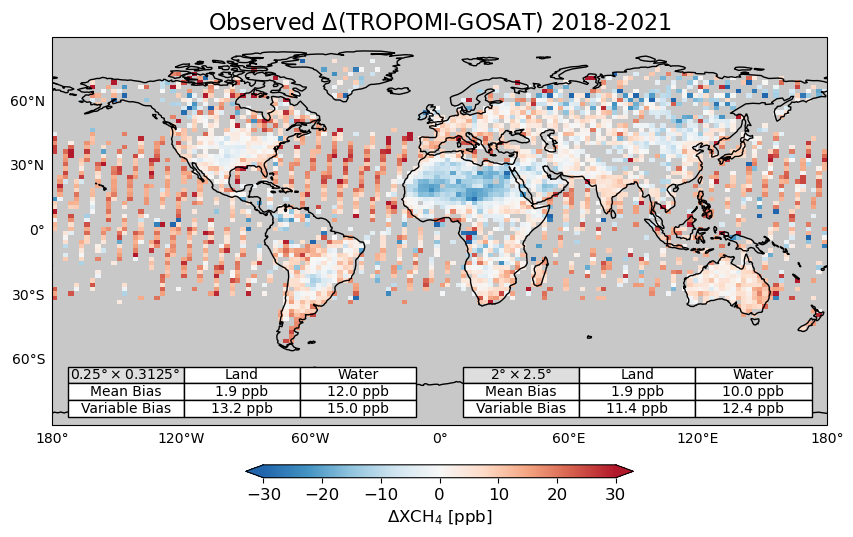

In [137]:
fig,ax = plt.subplots(figsize=(10,10), subplot_kw={"projection":ccrs.PlateCarree()})
ax.imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])

# Plot main grid
grid_2018_2021_all_2_25deg.plot(ax=ax, column=grid_2018_2021_all_2_25deg["true_delta_tropomi_gosat"], vmin=-30, vmax=30, cmap=tol_cmap("BuRd"))

# General map plotting things
ax.coastlines()
ax.set_global()
gl = ax.gridlines(draw_labels=True, zorder=-1, linewidth=0)
gl.top_labels = gl.right_labels = False

# Add table of values for 0.25 x 0.3125
col_labels=[r'$0.25\degree \times 0.3125\degree$','Land','Water']
table_vals=[["Mean Bias",f"{np.mean(grid_2018_2021_land_025_03125deg['true_delta_tropomi_gosat']):.1f} ppb", f"{np.mean(grid_2018_2021_water_025_03125deg['true_delta_tropomi_gosat']):.1f} ppb"],\
            ["Variable Bias",f"{np.std(grid_2018_2021_land_025_03125deg['true_delta_tropomi_gosat']):.1f} ppb", f"{np.std(grid_2018_2021_water_025_03125deg['true_delta_tropomi_gosat']):.1f} ppb"]]
table = plt.table(cellText=table_vals,
                  colWidths = [0.09]*3,
                  colLabels=col_labels,
                  colColours=["#dedede","white","white"],
                  cellLoc="center",
                  rowLoc="center",
                  bbox=[0.02,0.02,0.45,0.13],
                  zorder=2)
table.auto_set_font_size(False)
table.set_fontsize(10)

# Add table of values for 2 x 2.5
col_labels=[r'$2\degree \times 2.5\degree$','Land','Water']
table_vals=[["Mean Bias",f"{np.mean(grid_2018_2021_land_2_25deg['true_delta_tropomi_gosat']):.1f} ppb", f"{np.mean(grid_2018_2021_water_2_25deg['true_delta_tropomi_gosat']):.1f} ppb"],\
            ["Variable Bias",f"{np.std(grid_2018_2021_land_2_25deg['true_delta_tropomi_gosat']):.1f} ppb", f"{np.std(grid_2018_2021_water_2_25deg['true_delta_tropomi_gosat']):.1f} ppb"]]
table = plt.table(cellText=table_vals,
                  colWidths = [0.09]*3,
                  colLabels=col_labels,
                  colColours=["#dedede","white","white"],
                  cellLoc="center",
                  rowLoc="center",
                  bbox=[0.53,0.02,0.45,0.13],
                  zorder=2)
table.auto_set_font_size(False)
table.set_fontsize(10)

# Add colorbar and title
fig.subplots_adjust(hspace=-0.35,wspace=0.01)
cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-30, vmax=30), cmap=tol_cmap("BuRd"))
cb = fig.colorbar(cbar, ax=ax, location="bottom", aspect=30.0, pad=0.052, shrink=0.5, extend="both")
cb.set_label(f"$\Delta$XCH$_4$ [ppb]", fontsize=12)
cb.ax.tick_params(labelsize=12) 
ax.set_title(f"Observed $\Delta$(TROPOMI-GOSAT) 2018-2021", fontsize=16)

fig.savefig("./paper_figures/fig1.png",bbox_inches="tight",dpi=300)

### Figure 2

In [9]:
with open(config["StorageDir"] + "/pkl/flaml/shap_values_train.pkl", "rb") as handle:
    shap_values_train = pickle.load(handle)

new_feature_names = []
new_feature_names_dict = {"tropomi_swir_surface_albedo":"SWIR Surface Albedo","tropomi_vza":"Viewing Zenith Angle","tropomi_aerosol_size":"Aerosol Size Distribution Parameter","tropomi_aerosol_column":"Aerosol Column","tropomi_swir_aerosol_optical_thickness":"SWIR Aerosol Optical Thickness",\
                          "tropomi_xch4_precision":"XCH$_4$ Precision","tropomi_fluorescence":"Fluorescence","tropomi_nir_surface_albedo_precision":"NIR Surface Albedo Precision","tropomi_co_column_precision":"CO Column Precision",\
                          "tropomi_nir_surface_albedo":"NIR Surface Albedo","tropomi_aerosol_size":"Aerosol Size Distribution Parameter","tropomi_aerosol_altitude":"Aerosol Height","tropomi_aerosol_size_precision":"Aerosol Size Distribution Parameter Precision",\
                          "tropomi_nir_aerosol_optical_thickness":"NIR Aerosol Optical Thickness","tropomi_aerosol_altitude_precision":"Aerosol Height Precision","tropomi_co_column":"CO Column","tropomi_u10":"U10","tropomi_v10":"V10",\
                          "tropomi_xch4_apriori":"XCH$_4$ $\it{a}$ $\it{priori}$","tropomi_ground_pixel":"Across-Track Pixel Index","tropomi_nir_chi_squared_band":"NIR Chi Squared Band","tropomi_swir_chi_squared_band":"SWIR Chi Squared Band",\
                          "tropomi_swir_surface_albedo_precision":"SWIR Surface Albedo Precision","tropomi_h2o_column_precision":"H$_2$O Column Precision","tropomi_surface_altitude":"Surface Altitude",\
                          "tropomi_surface_altitude_stdv":"Surface Altitude Stdv","tropomi_h2o_column":"H$_2$O Column","tropomi_raa":"Relative Azimuth Angle","tropomi_sza":"Solar Zenith Angle","tropomi_landflag":"Land Flag","tropomi_aerosol_column_precision":"Aerosol Column Precision",\
                          "tropomi_cirrus_reflectance":"Cirrus Reflectance"}
for key in shap_values_train.feature_names:
    if key in new_feature_names_dict.keys():
        new_feature_names.append(new_feature_names_dict[key])
    else:
        new_feature_names.append(key)
shap_values_train.feature_names = new_feature_names

In [10]:
mean_abs_shap = np.zeros((len(shap_values_train.feature_names)))
std_abs_shap = np.zeros((len(shap_values_train.feature_names)))

for idx,key in enumerate(shap_values_train.feature_names):
    mean_abs_shap[idx] = np.mean(np.abs(shap_values_train[:,key].values))
    std_abs_shap[idx] = np.std(np.abs(shap_values_train[:,key].values))
    
abs_shap = pd.DataFrame({"feature_names":shap_values_train.feature_names,"mean_abs_shap":mean_abs_shap,"std_abs_shap":std_abs_shap})

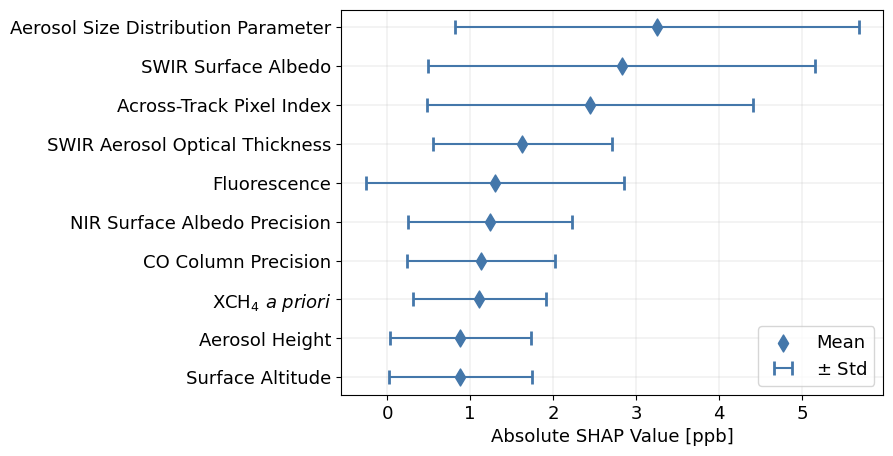

In [11]:
abs_shap_subset = abs_shap.sort_values("mean_abs_shap").iloc[-10:]
fig,ax = plt.subplots(figsize=(7,5))

ax.grid(linewidth=0.2)
ax.scatter(abs_shap_subset["mean_abs_shap"],abs_shap_subset["feature_names"],s=75,label="Mean",color="#4477AA",marker="d")
ax.errorbar(abs_shap_subset["mean_abs_shap"],abs_shap_subset["feature_names"],xerr=abs_shap_subset["std_abs_shap"],capsize=5,capthick=2,linestyle="",label=f"$\pm$ Std",color="#4477AA")
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel("Absolute SHAP Value [ppb]", fontsize=13)
ax.legend(loc="lower right",fontsize=13)

fig.savefig("./paper_figures/fig2.png", bbox_inches="tight", dpi=300)

In [28]:
print(f"R2 = {r(shap_values_train[:,'SWIR Aerosol Optical Thickness'].data,shap_values_train[:,'Aerosol Size Distribution Parameter'].data)**2}")

R2 = 0.6939721867115509


In [33]:
print(f"R2 = {r(shap_values_train[:,'SWIR Surface Albedo'].data,shap_values_train[:,'Aerosol Size Distribution Parameter'].data)**2}")

R2 = 0.01793439742468147


### Figure 3

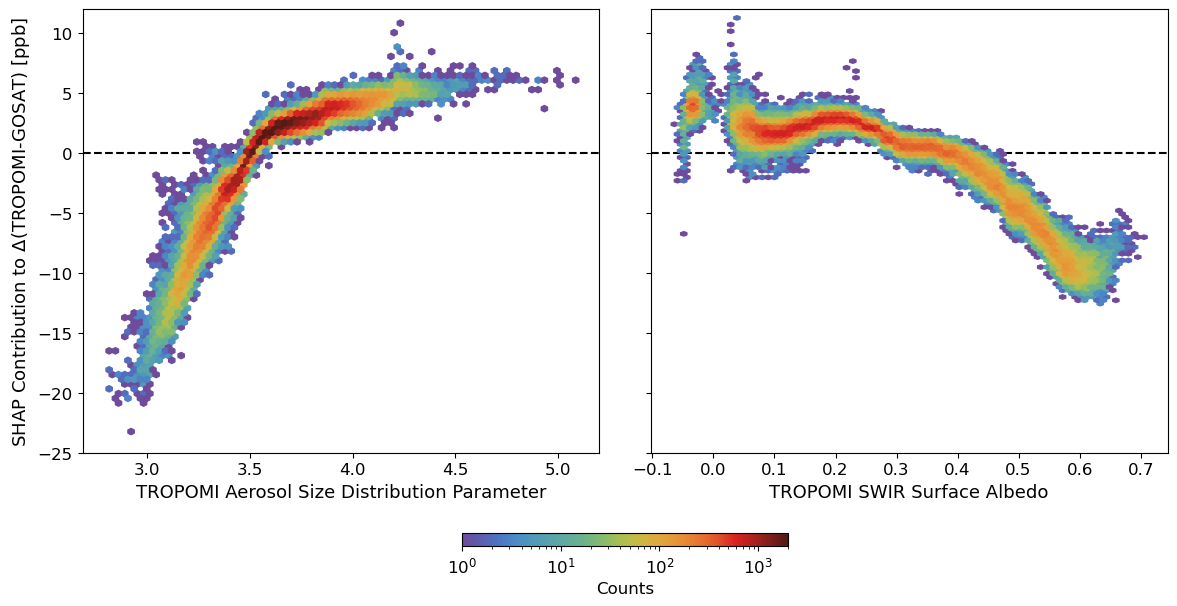

In [29]:
fig,ax = plt.subplots(1,2,figsize=(14,8),sharey=True)

ax[0].axhline(0,linestyle="--",color="k",zorder=-1)
ax[0].hexbin(shap_values_train[:,"Aerosol Size Distribution Parameter"].data, shap_values_train[:,"Aerosol Size Distribution Parameter"].values, gridsize=75, bins='log', cmap=tol_cmap("rainbow_PuBr"), vmin=1, vmax=2000)
ax[0].set_xlabel("TROPOMI Aerosol Size Distribution Parameter",fontsize=13)
ax[0].set_ylabel("SHAP Contribution to $\Delta$(TROPOMI-GOSAT) [ppb]",fontsize=13)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_ylim([-25,12])

ax[1].axhline(0,linestyle="--",color="k",zorder=-1)
hb = ax[1].hexbin(shap_values_train[:,"SWIR Surface Albedo"].data, shap_values_train[:,"SWIR Surface Albedo"].values, gridsize=75, bins='log', cmap=tol_cmap("rainbow_PuBr"), vmin=1, vmax=2000)
ax[1].set_xlabel("TROPOMI SWIR Surface Albedo",fontsize=13)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_ylim([-25,12])

fig.subplots_adjust(wspace=0.1)
cb = fig.colorbar(hb, ax=ax, location="bottom", pad=0.13, aspect=25, shrink=0.3)
cb.set_label("Counts", fontsize=12)
cb.ax.tick_params(labelsize=12) 
fig.savefig("./paper_figures/fig3.png", bbox_inches="tight", dpi=300)

### Figure 4

In [8]:
flaml_dir = config["StorageDir"] + "/pkl/flaml/"
pairs = pd.read_pickle(flaml_dir+"filtered_tropomi_gosat_pairs.pkl").sort_values("tropomi_time").reset_index(drop=True)

train_index = pairs[pairs["tropomi_time"] < datetime.datetime(2021,1,1,0,0,0)].index
test_index = pairs[pairs["tropomi_time"] >= datetime.datetime(2021,1,1,0,0,0)].index

X = pairs[["tropomi_sza","tropomi_raa","tropomi_surface_altitude","tropomi_surface_altitude_stdv","tropomi_u10","tropomi_v10",\
               "tropomi_cirrus_reflectance","tropomi_xch4_precision","tropomi_xch4_apriori","tropomi_fluorescence","tropomi_co_column",\
               "tropomi_co_column_precision","tropomi_h2o_column","tropomi_h2o_column_precision","tropomi_aerosol_size","tropomi_aerosol_size_precision","tropomi_aerosol_column",\
               "tropomi_aerosol_column_precision","tropomi_aerosol_altitude","tropomi_aerosol_altitude_precision","tropomi_nir_surface_albedo","tropomi_swir_surface_albedo",\
               "tropomi_nir_surface_albedo_precision","tropomi_swir_surface_albedo_precision","tropomi_nir_aerosol_optical_thickness","tropomi_swir_aerosol_optical_thickness",\
               "tropomi_nir_chi_squared_band","tropomi_swir_chi_squared_band","tropomi_ground_pixel","tropomi_landflag"]]

y = pairs["delta_tropomi_gosat"]

X_train, y_train = X.loc[train_index], y.loc[train_index]
X_test, y_test = X.loc[test_index], y.loc[test_index]

with open(config["StorageDir"] + f"/pkl/flaml/model_{config['Model']}.pkl", "rb") as handle:
    model = pickle.load(handle)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f"Using the {config['Model']} model.")

Using the lgbm model.


In [11]:
a = np.std(y_train)/np.std(y_train_pred)
b = np.mean(y_train) - a*np.mean(y_train_pred)
print(f"For Z-score transform, a = {a:.2f} and b = {b:.2f}")
print(f"In config.yml, a = {config['a']} and b = {config['b']}")
print("These should match.")

For Z-score transform, a = 1.26 and b = 0.13
In config.yml, a = 1.26 and b = 0.13
These should match.


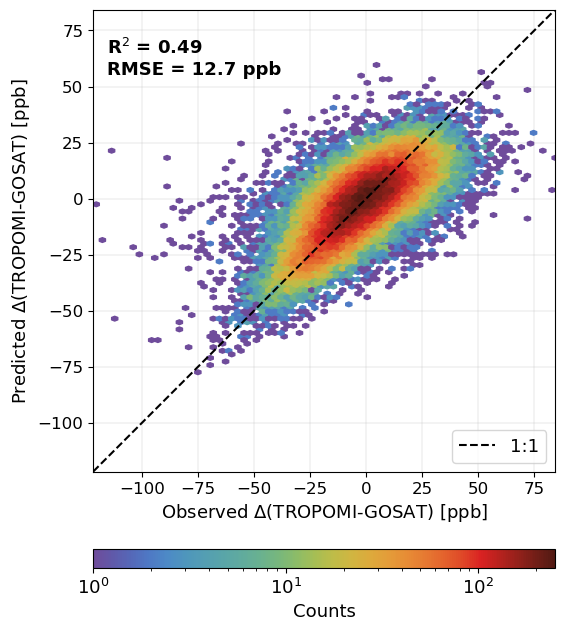

In [18]:
fig,ax = plt.subplots(figsize=(6,6),subplot_kw={"box_aspect":1})

ax.grid(linewidth=0.2)
ax.set_axisbelow(True)
xplot,yplot = y_test, config["a"]*y_test_pred + config["b"]
min_,max_ = min(np.min(xplot),np.min(yplot)),max(np.max(xplot),np.max(yplot))
hb = ax.hexbin(xplot, yplot, gridsize=75, bins='log', cmap=tol_cmap("rainbow_PuBr"))
ax.plot([min_,max_],[min_,max_],linestyle="--",color="k",label="1:1")
ax.set(xlim=[min_,max_], ylim=[min_,max_])
ax.set_xlabel(f"Observed $\Delta$(TROPOMI-GOSAT) [ppb]", fontsize=13)
ax.set_ylabel(f"Predicted $\Delta$(TROPOMI-GOSAT) [ppb]", fontsize=13)
ax.text(0.03, 0.86, f"R$^2$ = {r(xplot,yplot)**2:.2f}\nRMSE = {rmse(xplot,yplot):.1f} ppb", transform=ax.transAxes, fontsize=13, weight="bold")
ax.legend(loc="lower right",fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=12)

left, bottom, width, height = ax.get_position().bounds
cax = fig.add_axes([left, -0.05, width, height*0.04])
cb = plt.colorbar(hb, orientation='horizontal', cax=cax)
cb.set_label("Counts", fontsize=13)
cb.ax.tick_params(labelsize=13)

fig.savefig("./paper_figures/fig4.png", bbox_inches="tight", dpi=300)

### Figure 5

In [51]:
# Read in geopandas grids
grid_2021_all_2_25deg = geopandas.read_file(config["StorageDir"] + f"/geojson/Paired_Global_All_2021_2_25deg.geojson")
grid_2021_all_025_03125deg = geopandas.read_file(config["StorageDir"] + f"/geojson/Paired_Global_All_2021_025_03125deg.geojson")

grid_2021_land_2_25deg = geopandas.read_file(config["StorageDir"] + f"/geojson/Paired_Global_Land_2021_2_25deg.geojson")
grid_2021_land_025_03125deg = geopandas.read_file(config["StorageDir"] + f"/geojson/Paired_Global_Land_2021_025_03125deg.geojson")

grid_2021_water_2_25deg = geopandas.read_file(config["StorageDir"] + f"/geojson/Paired_Global_Water_2021_2_25deg.geojson")
grid_2021_water_025_03125deg = geopandas.read_file(config["StorageDir"] + f"/geojson/Paired_Global_Water_2021_025_03125deg.geojson")

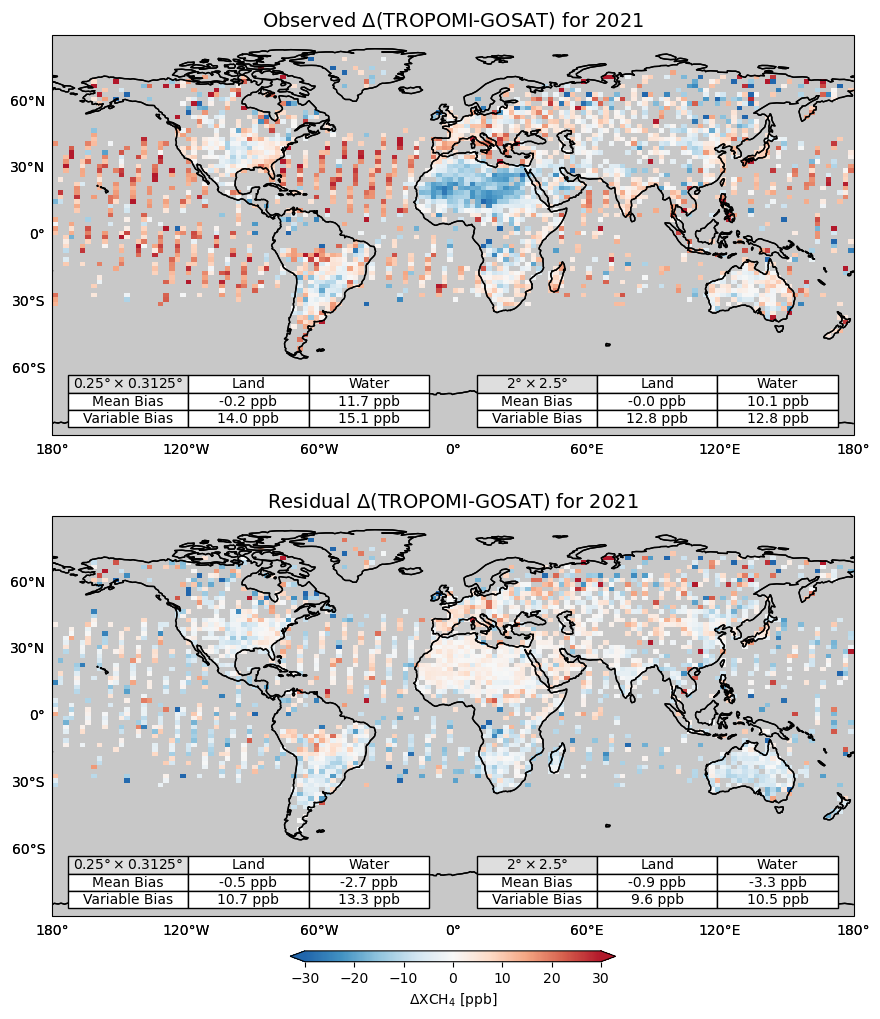

In [53]:
fig,ax = plt.subplots(2,1,figsize=(14,14), subplot_kw={"projection":ccrs.PlateCarree()})
for i in [0,1]:
    ax[i].coastlines()
    ax[i].set_global()
    gl = ax[i].gridlines(draw_labels=True, zorder=-1, linewidth=0)
    gl.top_labels = gl.right_labels = False
    ax[i].imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])

## Plot 1
grid_2021_all_2_25deg.plot(ax=ax[0], column=grid_2021_all_2_25deg["true_delta_tropomi_gosat"], vmin=-30, vmax=30, cmap=tol_cmap("BuRd"))
ax[0].set_title(f"Observed $\Delta$(TROPOMI-GOSAT) for 2021", fontsize=14)

# Add table of values for 0.25 x 0.3125
col_labels=[r'$0.25\degree \times 0.3125\degree$','Land','Water']
table_vals=[["Mean Bias",f"{np.mean(grid_2021_land_025_03125deg['true_delta_tropomi_gosat']):.1f} ppb", f"{np.mean(grid_2021_water_025_03125deg['true_delta_tropomi_gosat']):.1f} ppb"],\
            ["Variable Bias",f"{np.std(grid_2021_land_025_03125deg['true_delta_tropomi_gosat']):.1f} ppb", f"{np.std(grid_2021_water_025_03125deg['true_delta_tropomi_gosat']):.1f} ppb"]]
table = ax[0].table(cellText=table_vals,
                  colWidths = [0.09]*3,
                  colLabels=col_labels,
                  colColours=["#dedede","white","white"],
                  cellLoc="center",
                  rowLoc="center",
                  bbox=[0.02,0.02,0.45,0.13],
                  zorder=2)
table.auto_set_font_size(False)
table.set_fontsize(10)

# Add table of values for 2 x 2.5
col_labels=[r'$2\degree \times 2.5\degree$','Land','Water']
table_vals=[["Mean Bias",f"{np.mean(grid_2021_land_2_25deg['true_delta_tropomi_gosat']):.1f} ppb", f"{np.mean(grid_2021_water_2_25deg['true_delta_tropomi_gosat']):.1f} ppb"],\
            ["Variable Bias",f"{np.std(grid_2021_land_2_25deg['true_delta_tropomi_gosat']):.1f} ppb", f"{np.std(grid_2021_water_2_25deg['true_delta_tropomi_gosat']):.1f} ppb"]]
table = ax[0].table(cellText=table_vals,
                  colWidths = [0.09]*3,
                  colLabels=col_labels,
                  colColours=["#dedede","white","white"],
                  cellLoc="center",
                  rowLoc="center",
                  bbox=[0.53,0.02,0.45,0.13],
                  zorder=2)
table.auto_set_font_size(False)
table.set_fontsize(10)

## Plot 2
grid_2021_all_2_25deg.plot(ax=ax[1], column=grid_2021_all_2_25deg["residual_delta_tropomi_gosat"], vmin=-30, vmax=30, cmap=tol_cmap("BuRd"))
ax[1].set_title(f"Residual $\Delta$(TROPOMI-GOSAT) for 2021", fontsize=14)

# Add table of values for 0.25 x 0.3125
col_labels=[r'$0.25\degree \times 0.3125\degree$','Land','Water']
table_vals=[["Mean Bias",f"{np.mean(grid_2021_land_025_03125deg['residual_delta_tropomi_gosat']):.1f} ppb", f"{np.mean(grid_2021_water_025_03125deg['residual_delta_tropomi_gosat']):.1f} ppb"],\
            ["Variable Bias",f"{np.std(grid_2021_land_025_03125deg['residual_delta_tropomi_gosat']):.1f} ppb", f"{np.std(grid_2021_water_025_03125deg['residual_delta_tropomi_gosat']):.1f} ppb"]]
table = ax[1].table(cellText=table_vals,
                  colWidths = [0.09]*3,
                  colLabels=col_labels,
                  colColours=["#dedede","white","white"],
                  cellLoc="center",
                  rowLoc="center",
                  bbox=[0.02,0.02,0.45,0.13],
                  zorder=2)
table.auto_set_font_size(False)
table.set_fontsize(10)

# Add table of values for 2 x 2.5
col_labels=[r'$2\degree \times 2.5\degree$','Land','Water']
table_vals=[["Mean Bias",f"{np.mean(grid_2021_land_2_25deg['residual_delta_tropomi_gosat']):.1f} ppb", f"{np.mean(grid_2021_water_2_25deg['residual_delta_tropomi_gosat']):.1f} ppb"],\
            ["Variable Bias",f"{np.std(grid_2021_land_2_25deg['residual_delta_tropomi_gosat']):.1f} ppb", f"{np.std(grid_2021_water_2_25deg['residual_delta_tropomi_gosat']):.1f} ppb"]]
table = ax[1].table(cellText=table_vals,
                  colWidths = [0.09]*3,
                  colLabels=col_labels,
                  colColours=["#dedede","white","white"],
                  cellLoc="center",
                  rowLoc="center",
                  bbox=[0.53,0.02,0.45,0.13],
                  zorder=2)
table.auto_set_font_size(False)
table.set_fontsize(10)

for i in [0,1]:
    ax[i].coastlines()
    ax[i].set_global()
    gl = ax[i].gridlines(draw_labels=True, zorder=-1, linewidth=0)
    gl.top_labels = gl.right_labels = False

cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-30, vmax=30), cmap=tol_cmap("BuRd"))
ax_cbar = fig.colorbar(cbar, ax=ax, location="bottom", aspect=30.0, pad=0.032, shrink=0.3, extend="both", label=f"$\Delta$XCH$_4$ [ppb]")

fig.savefig("./paper_figures/fig5.png",bbox_inches="tight",dpi=300)

### Figure 6

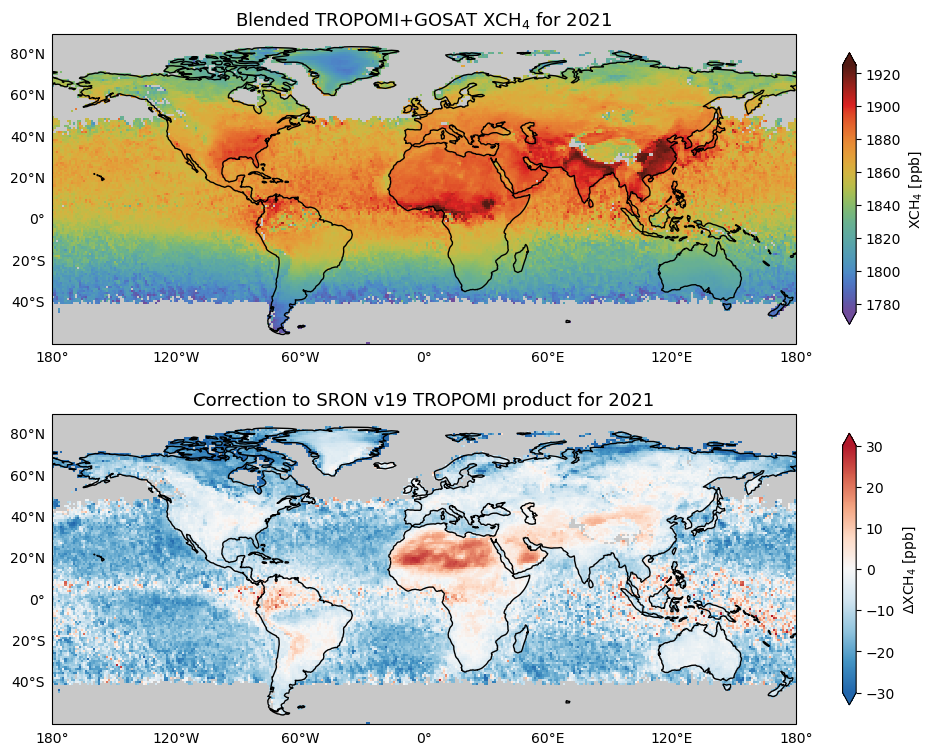

In [38]:
fig,ax = plt.subplots(2,1,figsize=(12,12), subplot_kw={"projection":ccrs.PlateCarree()})
for i in [0,1]:
    ax[i].coastlines()
    ax[i].set_global()
    gl = ax[i].gridlines(draw_labels=True, zorder=-1, linewidth=0)
    gl.top_labels = gl.right_labels = False
    ax[i].imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])
    ax[i].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())
    
grid = geopandas.read_file(config["StorageDir"] + "/geojson/TROPOMI_Global_2021_1deg.geojson")

grid.plot(ax=ax[0], column=grid["tropomi_xch4_blended_tropomi_gosat"], cmap=tol_cmap("rainbow_PuBr"), vmin=1775, vmax=1925, legend=True, legend_kwds={"extend":"both","label":f"XCH$_4$ [ppb]","shrink":0.5})
grid.plot(ax=ax[1], column=grid["tropomi_xch4_blended_tropomi_gosat"]-grid["tropomi_xch4_corrected"], cmap=tol_cmap("BuRd"), vmin=-30, vmax=30, legend=True, legend_kwds={"extend":"both","label":f"$\Delta$XCH$_4$ [ppb]","shrink":0.5})

ax[0].set_title("Blended TROPOMI+GOSAT XCH$_4$ for 2021",fontsize=13)
ax[1].set_title("Correction to SRON v19 TROPOMI product for 2021",fontsize=13)

fig.subplots_adjust(hspace=-0.3)
fig.savefig("./paper_figures/fig6.png", bbox_inches="tight", dpi=300)

In [51]:
print("Land + Water: Max, Min, Mean, Std")
grid = geopandas.read_file(config["StorageDir"] + "/geojson/TROPOMI_Global_2021_1deg.geojson")
north60 = shapely.geometry.Polygon(zip([-180,-180,180,180],[-60,90,90,-60]))
north60_idx = grid["geometry"].intersects(north60)
grid_north60 = grid[north60_idx]

print(np.max(grid_north60["tropomi_xch4_blended_tropomi_gosat"]-grid_north60["tropomi_xch4_corrected"]))
print(np.min(grid_north60["tropomi_xch4_blended_tropomi_gosat"]-grid_north60["tropomi_xch4_corrected"]))
print(np.mean(grid_north60["tropomi_xch4_blended_tropomi_gosat"]-grid_north60["tropomi_xch4_corrected"]))
print(np.std(grid_north60["tropomi_xch4_blended_tropomi_gosat"]-grid_north60["tropomi_xch4_corrected"]))
print("")

print("Land: Max, Min, Mean, Std")
grid = geopandas.read_file(config["StorageDir"] + "/geojson/TROPOMI_Land_2021_1deg.geojson")
north60 = shapely.geometry.Polygon(zip([-180,-180,180,180],[-60,90,90,-60]))
north60_idx = grid["geometry"].intersects(north60)
grid_north60 = grid[north60_idx]
print(np.max(grid_north60["tropomi_xch4_blended_tropomi_gosat"]-grid_north60["tropomi_xch4_corrected"]))
print(np.min(grid_north60["tropomi_xch4_blended_tropomi_gosat"]-grid_north60["tropomi_xch4_corrected"]))
print(np.mean(grid_north60["tropomi_xch4_blended_tropomi_gosat"]-grid_north60["tropomi_xch4_corrected"]))
print(np.std(grid_north60["tropomi_xch4_blended_tropomi_gosat"]-grid_north60["tropomi_xch4_corrected"]))
print("")

print("Water: Max, Min, Mean, Std")
grid = geopandas.read_file(config["StorageDir"] + "/geojson/TROPOMI_Water_2021_1deg.geojson")
north60 = shapely.geometry.Polygon(zip([-180,-180,180,180],[-60,90,90,-60]))
north60_idx = grid["geometry"].intersects(north60)
grid_north60 = grid[north60_idx]
print(np.max(grid_north60["tropomi_xch4_blended_tropomi_gosat"]-grid_north60["tropomi_xch4_corrected"]))
print(np.min(grid_north60["tropomi_xch4_blended_tropomi_gosat"]-grid_north60["tropomi_xch4_corrected"]))
print(np.mean(grid_north60["tropomi_xch4_blended_tropomi_gosat"]-grid_north60["tropomi_xch4_corrected"]))
print(np.std(grid_north60["tropomi_xch4_blended_tropomi_gosat"]-grid_north60["tropomi_xch4_corrected"]))

Land + Water: Max, Min, Mean, Std
45.33249189694743
-57.83664917562896
-8.907791319515567
9.542491973139956

Land: Max, Min, Mean, Std
33.93038064006964
-50.74141275128022
-5.440581280471152
9.78972638752073

Water: Max, Min, Mean, Std
45.33249189694743
-71.60851122742292
-12.714090383511607
9.643520176087248


In [52]:
print("Land + Water: Max, Min, Mean, Std")
grid = geopandas.read_file(config["StorageDir"] + "/geojson/TROPOMI_Global_2021_1deg.geojson")
south60 = shapely.geometry.Polygon(zip([-180,-180,180,180],[-90,-60,-60,-90]))
south60_idx = grid["geometry"].intersects(north60)
grid_south60 = grid[south60_idx]

print(np.max(grid_south60["tropomi_xch4_blended_tropomi_gosat"]-grid_south60["tropomi_xch4_corrected"]))
print(np.min(grid_south60["tropomi_xch4_blended_tropomi_gosat"]-grid_south60["tropomi_xch4_corrected"]))
print(np.mean(grid_south60["tropomi_xch4_blended_tropomi_gosat"]-grid_south60["tropomi_xch4_corrected"]))
print(np.std(grid_south60["tropomi_xch4_blended_tropomi_gosat"]-grid_south60["tropomi_xch4_corrected"]))

Land + Water: Max, Min, Mean, Std
45.33249189694743
-57.83664917562896
-8.907791319515567
9.542491973139956


### Figure 7

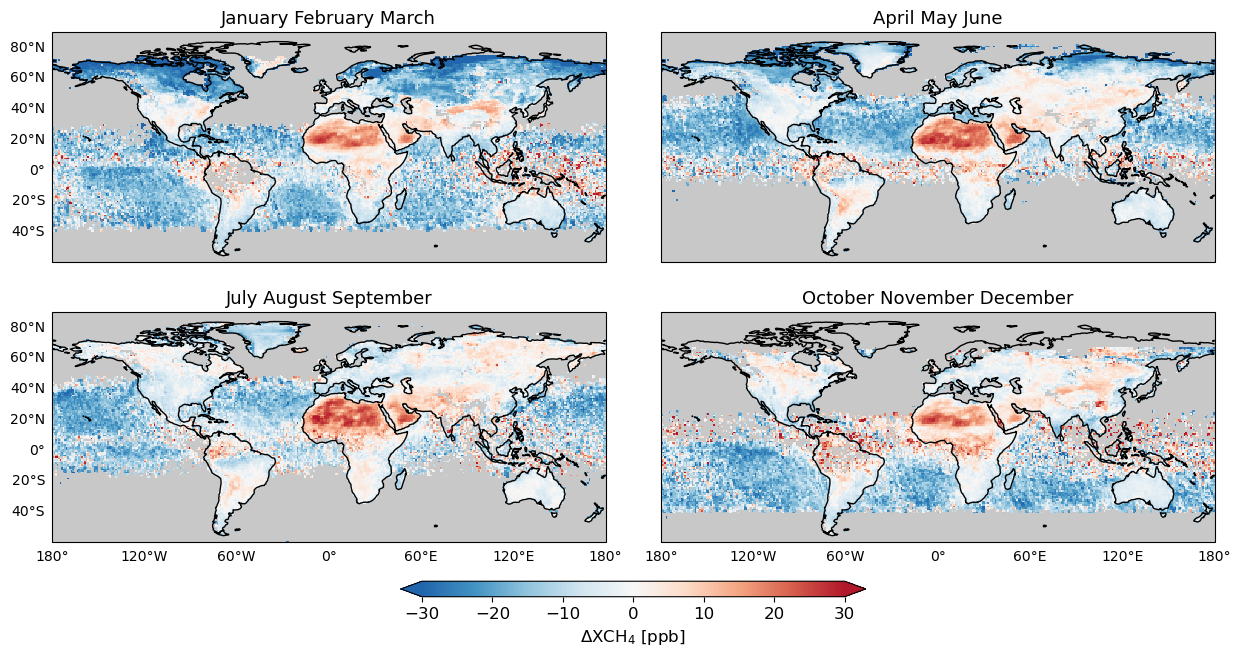

In [34]:
fig,ax = plt.subplots(2,2, figsize=(15,12), subplot_kw={"projection":ccrs.PlateCarree()})
for i in [0,1]: # add gray background
    for j in [0,1]:
        ax[i,j].imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])

grid = geopandas.read_file(config["StorageDir"] + f"/geojson/TROPOMI_Global_Jan_Mar_2021_1deg.geojson")
grid.plot(ax=ax[0,0], column=grid["tropomi_xch4_blended_tropomi_gosat"]-grid["tropomi_xch4_corrected"], vmin=-30, vmax=30, cmap=tol_cmap("BuRd"))
ax[0,0].set_title("January February March", fontsize=13)

grid = geopandas.read_file(config["StorageDir"] + f"/geojson/TROPOMI_Global_Apr_Jun_2021_1deg.geojson")
grid.plot(ax=ax[0,1], column=grid["tropomi_xch4_blended_tropomi_gosat"]-grid["tropomi_xch4_corrected"], vmin=-30, vmax=30, cmap=tol_cmap("BuRd"))
ax[0,1].set_title("April May June", fontsize=13)

grid = geopandas.read_file(config["StorageDir"] + f"/geojson/TROPOMI_Global_Jul_Sep_2021_1deg.geojson")
grid.plot(ax=ax[1,0], column=grid["tropomi_xch4_blended_tropomi_gosat"]-grid["tropomi_xch4_corrected"], vmin=-30, vmax=30, cmap=tol_cmap("BuRd"))
ax[1,0].set_title("July August September", fontsize=13)

grid = geopandas.read_file(config["StorageDir"] + f"/geojson/TROPOMI_Global_Oct_Dec_2021_1deg.geojson")
grid.plot(ax=ax[1,1], column=grid["tropomi_xch4_blended_tropomi_gosat"]-grid["tropomi_xch4_corrected"], vmin=-30, vmax=30, cmap=tol_cmap("BuRd"))
ax[1,1].set_title("October November December", fontsize=13)

for i in [0,1]:
    for j in [0,1]:
            ax[i,j].coastlines()
            ax[i,j].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())
            gl = ax[i,j].gridlines(draw_labels=True, zorder=-1, linewidth=0)
            gl.top_labels = gl.right_labels = False
            if i == 0:
                gl.bottom_labels = False
            if j == 1:
                gl.left_labels = False

fig.subplots_adjust(hspace=-0.4,wspace=0.1)
cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-30, vmax=30), cmap=tol_cmap("BuRd"))
cb = fig.colorbar(cbar, ax=ax, location="bottom", aspect=30.0, pad=0.042, shrink=0.4, extend="both")
cb.set_label(f"$\Delta$XCH$_4$ [ppb]", fontsize=12)
cb.ax.tick_params(labelsize=12) 

fig.savefig("./paper_figures/fig7.png",bbox_inches="tight",dpi=300)

### Figure 8

In [49]:
basename,res,extent = "TROPOMI_NorthAfrica_2021",0.01,[25,65,8,35]

blended = pd.read_fwf(f"{config['StorageDir']}/oversample/output/{basename}_Blended_oversampled{res}.csv", header=None, widths=[6,6,12,12,15,6], names=["row","col","lat","lon","xch4_blended","n"], usecols=["lat","lon","xch4_blended","n"])
sron = pd.read_fwf(f"{config['StorageDir']}/oversample/output/{basename}_SRON_oversampled{res}.csv", header=None, widths=[6,6,12,12,15,6], names=["row","col","lat","lon","xch4_corrected","n"], usecols=["lat","lon","xch4_corrected","n"])
albedo = pd.read_fwf(f"{config['StorageDir']}/oversample/output/{basename}_SWIR_Surface_albedo_oversampled{res}.csv", header=None, widths=[6,6,12,12,15,6], names=["row","col","lat","lon","swir_surface_albedo","n"], usecols=["lat","lon","swir_surface_albedo","n"])
aerosol = pd.read_fwf(f"{config['StorageDir']}/oversample/output/{basename}_Aerosol_size_oversampled{res}.csv", header=None, widths=[6,6,12,12,15,6], names=["row","col","lat","lon","aerosol_size","n"], usecols=["lat","lon","aerosol_size","n"])

patches = []
for i in blended.index:
    lon = blended.loc[i,"lon"]
    lat = blended.loc[i,"lat"]
    xmin = lon - res/2
    xmax = lon + res/2
    ymin = lat - res/2
    ymax = lat + res/2
    patches.append(Polygon(np.array(((xmin,ymin),(xmin,ymax),(xmax,ymax),(xmax,ymin)))))
    
blended_collection = PatchCollection(patches, array=blended["xch4_blended"], cmap=tol_cmap("rainbow_PuBr"))
blended_collection.set_clim(vmin=1850,vmax=1925)

sron_collection = PatchCollection(patches, array=sron["xch4_corrected"], cmap=tol_cmap("rainbow_PuBr"))
sron_collection.set_clim(vmin=1850,vmax=1925)

albedo_collection = PatchCollection(patches, array=albedo["swir_surface_albedo"], cmap=tol_cmap("rainbow_PuBr"))
albedo_collection.set_clim(vmin=0,vmax=0.6)

aerosol_collection = PatchCollection(patches, array=aerosol["aerosol_size"], cmap=tol_cmap("rainbow_PuBr"))
aerosol_collection.set_clim(vmin=3.2,vmax=3.8)

fig,ax = plt.subplots(2,2, figsize=(13,12), subplot_kw={"projection":ccrs.PlateCarree()})

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])
    
ax[0,0].add_collection(sron_collection)
ax[0,0].set_title("TROPOMI SRON v19",fontsize=13)
plt.colorbar(sron_collection, ax=ax[0,0], label=f"XCH$_4$ [ppb]", extend="both", shrink=0.45)
    
ax[0,1].add_collection(blended_collection)
ax[0,1].set_title("Blended TROPOMI+GOSAT",fontsize=13)
plt.colorbar(blended_collection, ax=ax[0,1], label=f"XCH$_4$ [ppb]", extend="both", shrink=0.45)

ax[1,0].add_collection(aerosol_collection)
ax[1,0].set_title("TROPOMI Aerosol Size Parameter",fontsize=13)
plt.colorbar(aerosol_collection, ax=ax[1,0], label=f"Aerosol Size Distribution Parameter", extend="both", shrink=0.45)

ax[1,1].add_collection(albedo_collection)
ax[1,1].set_title("TROPOMI SWIR Surface Albedo",fontsize=13)
plt.colorbar(albedo_collection, ax=ax[1,1], label=f"SWIR Surface Albedo", extend="both", shrink=0.45)

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].coastlines(linewidth=0.3,linestyle="--")
        ax[i,j].set_extent(extent, crs=ccrs.PlateCarree())
        ax[i,j].add_feature(cf.BORDERS, linewidth=0.3, linestyle="--")
        gl = ax[i,j].gridlines(draw_labels=True, zorder=-1, linewidth=0)
        gl.top_labels = gl.right_labels = False
    
fig.subplots_adjust(hspace=-0.47,wspace=0.15)
fig.savefig("./paper_figures/fig8.png", bbox_inches="tight", dpi=300)

### Figure 9

In [27]:
if os.path.exists("../tools/S5P_ultra_emitters_2019_2020.csv"):
    events = pd.read_csv("../tools/S5P_ultra_emitters_2019_2020.csv")
    print(events.iloc[274])

file = "s5p_l2_ch4_0446_11252.nc"
vmin, vmax=1830,1880
extent = [3,9,29,35]
shrink=0.5
ds = Dataset(f"/n/holylfs05/LABS/jacob_lab/nbalasus/blended_tropomi_gosat_methane/blended_tropomi_gosat/{file}")
xch4_corrected = ds["target_product/xch4_corrected"][:]
xch4_blended = ds["target_product/xch4_blended"][:]
cirrus = ds["/meteo/cirrus_reflectance"][:]
lat_center = ds["instrument/latitude_center"][:]
lon_center = ds["instrument/longitude_center"][:]
lat_corners = ds["instrument/latitude_corners"][:]
lon_corners = ds["instrument/longitude_corners"][:]

verts = [np.array([lon_corners[i,:],lat_corners[i,:]]).T for i in range(len(xch4_corrected))]

sron_collection = PolyCollection(verts, array=xch4_corrected, cmap=tol_cmap("rainbow_PuBr"))
sron_collection.set_clim(vmin=vmin, vmax=vmax)

blended_collection = PolyCollection(verts, array=xch4_blended, cmap=tol_cmap("rainbow_PuBr"))
blended_collection.set_clim(vmin=vmin, vmax=vmax)

difference_collection = PolyCollection(verts, array=xch4_blended-xch4_corrected, cmap=tol_cmap("BuRd"))
difference_collection.set_clim(vmin=-30, vmax=30)

cirrus_collection = PolyCollection(verts, array=cirrus, cmap=tol_cmap("rainbow_PuBr"))
cirrus_collection.set_clim(vmin=0,vmax=0.005)

fig,ax = plt.subplots(2,2, figsize=(10,10), subplot_kw={"projection":ccrs.PlateCarree()})
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].imshow(np.tile(np.array([[[220, 220, 220]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])

ax[0,0].add_collection(sron_collection)
ax[0,0].set_title("TROPOMI SRON v19")
plt.colorbar(sron_collection, ax=ax[0,0], label=f"XCH$_4$ [ppb]", shrink=shrink, extend="both")

ax[0,1].add_collection(blended_collection)
ax[0,1].set_title("Blended TROPOMI+GOSAT")
plt.colorbar(blended_collection, ax=ax[0,1], label=f"XCH$_4$ [ppb]", shrink=shrink, extend="both")

ax[1,0].add_collection(cirrus_collection)
ax[1,0].set_title("TROPOMI Cirrus Reflectance")
plt.colorbar(cirrus_collection, ax=ax[1,0], label=f"Cirrus Reflectance", shrink=shrink, extend="both")

ax[1,1].add_collection(difference_collection)
ax[1,1].set_title("Correction to TROPOMI SRON v19")
plt.colorbar(difference_collection, ax=ax[1,1], label=f"$\Delta$XCH$_4$ [ppb]", shrink=shrink, extend="both")

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].scatter(events.loc[274,"source_longitude_rough"],events.loc[274,"source_latitude_rough"],marker="x",color="k",s=75)
        ax[i,j].coastlines()
        ax[i,j].set_extent(extent, ccrs.PlateCarree())
        gl = ax[i,j].gridlines(draw_labels=True, zorder=-1, linewidth=0)
        gl.top_labels = gl.right_labels = False

fig.tight_layout()
fig.subplots_adjust(hspace=-0.3)
fig.savefig("./paper_figures/fig9.png",bbox_inches="tight",dpi=300)

date                        2019-12-15
event_id                          1296
emissions_rate_tons_hour           NaN
category                            og
source_latitude_rough            32.15
source_longitude_rough            6.14
Name: 274, dtype: object


### Figure B1

In [29]:
tccon = {
    "Bremen": (53.1,8.85),
    "Burgos": (18.5325,120.6496),
    "Pasadena": (34.136,-118.127),
    "Edwards": (34.959917, -117.881069),
    "East_Trout_Lake": (54.353738,-104.986667),
    "Eureka": (80.05,-86.42),
    "Garmisch-Partenkirchen": (47.476,11.063),
    "Hefei": (31.9, 117.17),
    "Izana": (28.3,-16.5),
    "Jet_Propulsion_Laboratory_2": (34.202,-118.175),
    "Saga": (33.24104,130.28818),
    "Karlsruhe": (49.1,8.438),
    "Lauder_2": (-45.038,169.684),
    "Lauder_3": (-45.038,169.684),
    "Nicosia": (35.141,33.381),
    "Ny-Ålesund": (78.923,11.923),
    "Lamont": (36.604,-97.486),
    "Orléans": (47.97,2.113),
    "Park_Falls": (45.945,-90.273),
    "Paris": (48.846,2.356),
    "Réunion_Island": (-20.901,55.485),
    "Rikubetsu": (43.46,143.77),
    "Sodankylä": (67.3668,26.631),
    "Tsukuba_2": (36.0513,140.1215),
    "Xianghe": (39.75,116.96)
}

fig,ax = plt.subplots(figsize=(10,10), subplot_kw={"projection":ccrs.PlateCarree()})
ax.imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])
grid_1 = geopandas.read_file(config["StorageDir"] + f"/geojson/TROPOMI_Global_2021_1deg.geojson")

grid_1.plot(ax=ax, column=grid_1["tropomi_swir_surface_albedo"], vmin=0, vmax=0.6, cmap=tol_cmap("rainbow_PuBr"))

ax.coastlines()
ax.set_global()
gl = ax.gridlines(draw_labels=True, zorder=-1, linewidth=0)
gl.top_labels = gl.right_labels = False

cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=0.6), cmap=tol_cmap("rainbow_PuBr"))
cb = fig.colorbar(cbar, ax=ax, location="bottom", aspect=30.0, pad=0.052, shrink=0.5, extend="both")
cb.set_label(f"SWIR Surface Albedo", fontsize=12)
cb.ax.tick_params(labelsize=12) 

for s in tccon.keys():
    ax.scatter(tccon[s][1], tccon[s][0], marker="x", color="red")
    
fig.savefig("./paper_figures/figb1.png", bbox_inches="tight", dpi=300)

In [45]:
def tccon_bias(satellite, file_suffix, n_threshold):
    tccon_stations = np.array(["Bremen","Burgos","Pasadena","Edwards","East_Trout_Lake","Eureka","Garmisch-Partenkirchen","Hefei","Izana","Jet_Propulsion_Laboratory_2","Saga","Karlsruhe",\
                            "Lauder","Nicosia","Ny-Ålesund","Lamont","Orléans","Park_Falls","Paris","Réunion_Island","Rikubetsu","Sodankylä","Tsukuba_2","Xianghe"])

    bias_by_station = np.zeros((len(tccon_stations)))
    n = np.zeros((len(tccon_stations)))
    scatter_by_station = np.zeros((len(tccon_stations)))

    for idx,station in enumerate(tccon_stations):
        if station == "Lauder":
            df = pd.concat([pd.read_pickle(config["StorageDir"] + f"/pkl/tccon/{satellite}/Lauder_2_{file_suffix}.pkl"),pd.read_pickle(config["StorageDir"] + f"/pkl/tccon/{satellite}/Lauder_3_{file_suffix}.pkl")], ignore_index=True)
        else:
            df = pd.read_pickle(config["StorageDir"] + f"/pkl/tccon/{satellite}/{station}_{file_suffix}.pkl")
            n[idx] = len(df)

    valid_idx = np.where(n > n_threshold)[0]
    print(f"Stations not used: {set(tccon_stations) - set(tccon_stations[valid_idx])}")
    tccon_stations = tccon_stations[valid_idx]
    bias_by_station = bias_by_station[valid_idx]
    n = n[valid_idx]
    scatter_by_station = scatter_by_station[valid_idx]

    for idx,station in enumerate(tccon_stations):
        if station == "Lauder":
            df = pd.concat([pd.read_pickle(config["StorageDir"] + f"/pkl/tccon/{satellite}/Lauder_2_{file_suffix}.pkl"),pd.read_pickle(config["StorageDir"] + f"/pkl/tccon/{satellite}/Lauder_3_{file_suffix}.pkl")], ignore_index=True)
        else:
            df = pd.read_pickle(config["StorageDir"] + f"/pkl/tccon/{satellite}/{station}_{file_suffix}.pkl")

        bias_by_station[idx] = np.mean(df[f"delta_{satellite}_tccon"])
        scatter_by_station[idx] = np.std(df[f"delta_{satellite}_tccon"])

    print(f"The global offset for {satellite} ({file_suffix}) is {np.mean(bias_by_station):.2f} ppb")
    print(f"The random error for {satellite} ({file_suffix}) is {np.mean(scatter_by_station):.2f} ppb")
    print(f"The relative accuracy for {satellite} ({file_suffix}) is {np.std(bias_by_station):.2f} ppb")
    print(f"Total TCCON/satellite pairs used was {np.sum(n)}\n")
    
    return bias_by_station,valid_idx

tccon_bias("gosat", "0.0ppb_offset", 100)
tccon_bias("gosat", "8.9ppb_offset", 100)
sron_bbs,idx = tccon_bias("tropomi", "SRONv19", 100)
blended_bbs,idx = tccon_bias("tropomi", "blended", 100)

Stations not used: {'Lauder', 'Ny-Ålesund', 'Izana'}
The global offset for gosat (0.0ppb_offset) is 8.90 ppb
The random error for gosat (0.0ppb_offset) is 15.28 ppb
The relative accuracy for gosat (0.0ppb_offset) is 5.28 ppb
Total TCCON/satellite pairs used was 34430.0

Stations not used: {'Lauder', 'Ny-Ålesund', 'Izana'}
The global offset for gosat (8.9ppb_offset) is -0.00 ppb
The random error for gosat (8.9ppb_offset) is 15.28 ppb
The relative accuracy for gosat (8.9ppb_offset) is 5.28 ppb
Total TCCON/satellite pairs used was 34430.0

Stations not used: {'Lauder', 'Ny-Ålesund', 'Izana', 'Réunion_Island'}
The global offset for tropomi (SRONv19) is 4.97 ppb
The random error for tropomi (SRONv19) is 13.86 ppb
The relative accuracy for tropomi (SRONv19) is 5.92 ppb
Total TCCON/satellite pairs used was 600831.0

Stations not used: {'Lauder', 'Ny-Ålesund', 'Izana', 'Réunion_Island'}
The global offset for tropomi (blended) is -3.00 ppb
The random error for tropomi (blended) is 11.78 ppb
The

### Figure C1

In [2]:
res,extent = 0.01,[-20,53,5,38]

blended_all = pd.read_fwf(f"{config['StorageDir']}/oversample/output/TROPOMI_NorthAfrica_2021_Blended_oversampled{res}.csv", header=None, widths=[6,6,12,12,15,6], names=["row","col","lat","lon","xch4_blended","n"], usecols=["lat","lon","xch4_blended","n"])
blended_filtered =  pd.read_fwf(f"{config['StorageDir']}/oversample/output/TROPOMI_NorthAfrica_Filter_2021_Blended_oversampled{res}.csv", header=None, widths=[6,6,12,12,15,6], names=["row","col","lat","lon","xch4_blended","n"], usecols=["lat","lon","xch4_blended","n"])

patches_all = []
for i in blended_all.index:
    lon = blended_all.loc[i,"lon"]
    lat = blended_all.loc[i,"lat"]
    xmin = lon - res/2
    xmax = lon + res/2
    ymin = lat - res/2
    ymax = lat + res/2
    patches_all.append(Polygon(np.array(((xmin,ymin),(xmin,ymax),(xmax,ymax),(xmax,ymin)))))
    
patches_filtered = []
for i in blended_filtered.index:
    lon = blended_filtered.loc[i,"lon"]
    lat = blended_filtered.loc[i,"lat"]
    xmin = lon - res/2
    xmax = lon + res/2
    ymin = lat - res/2
    ymax = lat + res/2
    patches_filtered.append(Polygon(np.array(((xmin,ymin),(xmin,ymax),(xmax,ymax),(xmax,ymin)))))

In [3]:
blended_collection = PatchCollection(patches_all, array=blended_all["xch4_blended"], cmap=tol_cmap("rainbow_PuBr"))
blended_collection.set_clim(vmin=1850,vmax=1925)

blended_filtered_collection = PatchCollection(patches_filtered, array=blended_filtered["xch4_blended"], cmap=tol_cmap("rainbow_PuBr"))
blended_filtered_collection.set_clim(vmin=1850,vmax=1925)

In [4]:
tropomi = pd.DataFrame(columns=["lat","lon","xch4"])
for num in np.arange(16679,21857):
    if os.path.exists(f"/n/holylfs05/LABS/jacob_lab/nbalasus/blended_tropomi_gosat_methane/blended_tropomi_gosat/s5p_l2_ch4_0446_{num}.nc"):
        ds = Dataset(f"/n/holylfs05/LABS/jacob_lab/nbalasus/blended_tropomi_gosat_methane/blended_tropomi_gosat/s5p_l2_ch4_0446_{num}.nc")
        v = ((ds["meteo/landflag"][:] == 3) | ((ds["meteo/landflag"][:] == 2) & (ds["diagnostics/chi_squared_band"][:][:,1] > 20)))
        v &= (ds["instrument/latitude_center"][:] > 0) & (ds["instrument/latitude_center"][:] < 40) & (ds["instrument/longitude_center"][:] > -20) & (ds["instrument/longitude_center"][:] < 65)
        lat = ds["instrument/latitude_center"][:][v]
        lon = ds["instrument/longitude_center"][:][v]
        xch4 = ds["target_product/xch4_corrected"][:][v]
        temp_df = pd.DataFrame({"lat":lat,"lon":lon,"xch4":xch4})
        tropomi = pd.concat([tropomi,temp_df])

In [5]:
fig,ax = plt.subplots(3,1, figsize=(10,20), subplot_kw={"projection":ccrs.PlateCarree()})

for i in [0,1,2]:
    ax[i].imshow(np.tile(np.array([[[200, 200, 200]]],dtype=np.uint8), [2, 2, 1]),origin='upper',transform=ccrs.PlateCarree(),extent=[-180, 180, -90, 90])
    
ax[0].add_collection(blended_collection)
ax[0].set_title("Blended TROPOMI+GOSAT (Pre-Filter)",fontsize=13)

cb = ax[1].scatter(tropomi["lon"],tropomi["lat"],c=tropomi["xch4"],cmap=tol_cmap("rainbow_PuBr"),vmin=1850,vmax=1925,s=1)
ax[1].set_title("Filtered-out Retrievals", fontsize=13)

ax[2].add_collection(blended_filtered_collection)
ax[2].set_title("Blended TROPOMI+GOSAT (Post-Filter)",fontsize=13)

plt.colorbar(cb, ax=ax, label=f"XCH$_4$ [ppb]", extend="both", location="bottom", pad=0.04, aspect=30)

for i in [0,1,2]:
    ax[i].coastlines(linewidth=0.3,linestyle="--")
    ax[i].set_extent(extent, crs=ccrs.PlateCarree())
    ax[i].add_feature(cf.BORDERS, linewidth=0.3, linestyle="--")
    gl = ax[i].gridlines(draw_labels=True, zorder=-1, linewidth=0)
    gl.top_labels = gl.right_labels = False
    
fig.savefig("./paper_figures/figc1.png", bbox_inches="tight", dpi=200)

### Extra Information

In [230]:
tropomi_files = os.listdir(config["StorageDir"] + "/blended_tropomi_gosat/")
len_landflag0,len_landflag1,len_landflag2,len_landflag3,len_all,len_filter = 0,0,0,0,0,0

for file in tropomi_files:
    
    ds = Dataset(config["StorageDir"] + f"/blended_tropomi_gosat/{file}")
    len_landflag0 += np.sum(ds["meteo/landflag"][:] == 0)
    len_landflag1 += np.sum(ds["meteo/landflag"][:] == 1)
    len_landflag2 += np.sum(ds["meteo/landflag"][:] == 2)
    len_landflag3 += np.sum(ds["meteo/landflag"][:] == 3)
    len_all       += len(ds["meteo/landflag"][:])
    len_filter    += np.sum((ds["meteo/landflag"][:] == 3) | ((ds["meteo/landflag"][:] == 2) & (ds["diagnostics/chi_squared_band"][:][:,1] > 20)))
    
print(len_landflag0,len_landflag1,len_landflag2,len_landflag3,len_all)

394081887 15233339 39738937 1342069 450396232


In [231]:
print(f"{100*(len_filter)/len_all:.1f}% of retrievals have (landflag == 3) | (landflag == 2 & SWIR chi2 > 20)")

1.2% of retrievals have (landflag == 3) | (landflag == 2 & SWIR chi2 > 20)


In [232]:
num_days_2018_2021 = len(pd.date_range(start="2018-01-01",end="2021-12-31",freq="d"))
print(f"{len_all/num_days_2018_2021:.1f} TROPOMI retrievals per day.")
print(f"{len(pd.read_pickle(config['StorageDir'] + '/pkl/gosat/gosat_data.pkl'))/num_days_2018_2021:.1f} GOSAT retrievals per day.")

308279.4 TROPOMI retrievals per day.
1453.5 GOSAT retrievals per day.
